# Exploratory Data Analysis

## <font color='salmon'>Project: Quora Insincere Questions Classification Project</font> 

The following notebook will explore the data set provided in the quora kaggle competition. 

In [138]:
# Loading libraries
from sklearn import metrics, naive_bayes, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm
import pickle
import matplotlib.pyplot as plt
import scipy.sparse


%matplotlib inline

# Loading helper functions
import helper as h
pd.set_option('float_format', '{:f}'.format)

# Avoid warnings
import warnings
warnings.filterwarnings('ignore')

## <font color='firebrick'>1. Preliminary Analysis</font> 
---

### 1.1 Word Level Exploration

In [6]:
# Loading Data
tqdm.pandas()
train_set = pd.read_csv('Data/train.csv', encoding = 'latin1')
print('Sample of sincere questions')
train_set[train_set.target == 0].sample(3, random_state = 3)

Sample of sincere questions


,qid,question_text,target
609611,775fb805432cf184d6f9,What do you think of Jallikattu?,0
251920,314cfd7b0a403233d4c0,How can a civil engineer earn well in structur...,0
750481,930783154f445fac3fb9,How many licks would it take to dissolve a nic...,0


In [7]:
print('Sample of insincere questions')
train_set[train_set.target == 1].sample(3, random_state = 20)

Sample of insincere questions


,qid,question_text,target
736959,90548d5140d3a0b4d36e,Do most of the Chinese regularly eat cockroach...,1
307200,3c2badc823240a49f725,"Hitler, Pol Pot, and Mao Zedong forced away th...",1
949791,ba1c7c2b0d952944f44f,Do Indians hate Chinese?,1


In [8]:
print('The data has {} rows and {} columns'.format(train_set.shape[0], train_set.shape[1]))

The data has 1048575 rows and 3 columns


Strong class imbalance. There are 64774 of insincere question that representthe 6.2% of the data


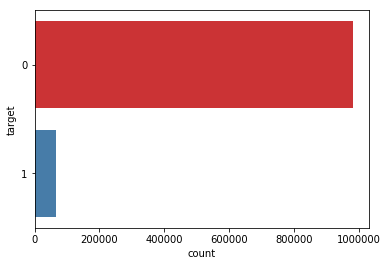

In [9]:
# Target variable count
ax = sns.countplot(y="target", data=train_set, palette="Set1") # strong class imbalance 
cnts = train_set.target.value_counts()
print("Strong class imbalance. " 
      "There are {} of insincere question that represent"
      "the {}% of the data".format(cnts[1], round(cnts[1]/sum(cnts)*100, 1)))

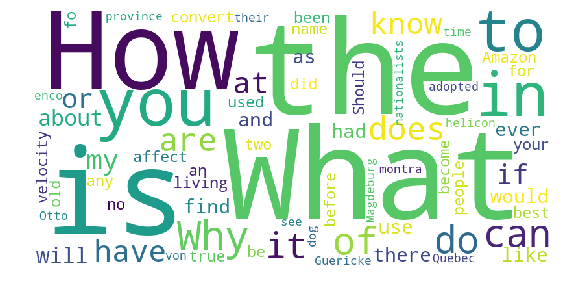

In [10]:
# WordCloud of unigram sincere questions
sincere_questions = train_set[train_set.target == 0].question_text
insincere_questions = train_set[train_set.target == 1].question_text

h.plot_wordcloud(sincere_questions, max_words=70, max_font_size=100,figure_size=(8,10), scale = 2, stop_words=['None'])

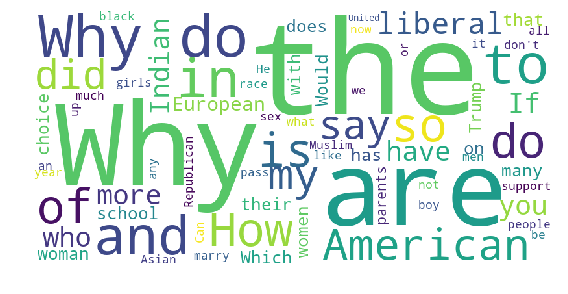

In [11]:
# WordCloud of unigram insincere questions
h.plot_wordcloud(insincere_questions, max_words=70, max_font_size=100, figure_size=(8,10), scale = 2, stop_words=[])

In [12]:
# Word Frequencies by target
wf_sincere = h.word_frequency(train_set.question_text[train_set.target==0])
wf_insincere = h.word_frequency(train_set.question_text[train_set.target==1])

100%|██████████| 64774/64774 [00:00<00:00, 157733.74it/s]


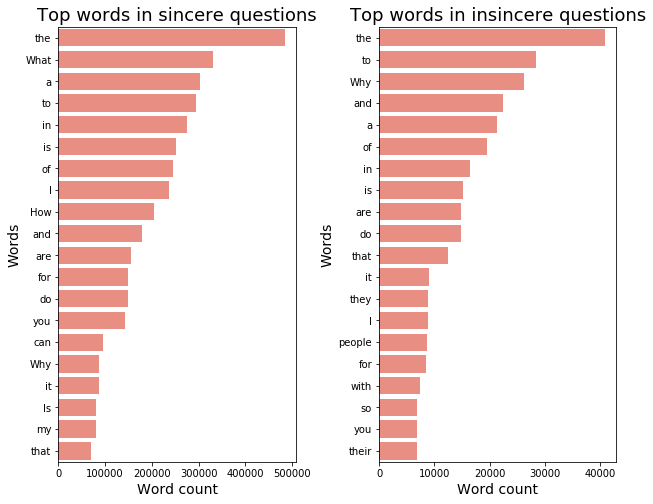

In [13]:
h.comparison_plot(wf_sincere[:20],wf_insincere[:20],'word','wordcount', .35)


Our data set consist of 3 columns, which only two are relevant for the task. The `target` column tags if a question is insincere or not, is our prediction goal. On the other hand, `question_text`column is our main focus. From this column all of the features must me derived for the classification task. 

As you can se from the plots and tables above, its very dificult to extract a pattern between target classes. The main reason is because each document is clouded by noise and common words that we call stopwords. So one important step will be eliminating this noise words and standarise each word to the same format. 

### 1.2 Document level exploration

I will now create basic meta document features to find macro structures and **outliers**.

In [14]:
# Creating several document derived features
train_set['char_count_full'] = train_set.question_text.progress_apply(len) # char clean count
train_set['word_count_full'] = train_set.question_text.progress_apply(lambda x: len(x.split())) # word clean count
train_set['word_density_full'] = train_set.char_count_full / (train_set.word_count_full+1) # word density count

100%|██████████| 1048575/1048575 [00:02<00:00, 393230.45it/s]


In [15]:
col = ['char_count_full', 'word_count_full', 'word_density_full']
pd.DataFrame(train_set.word_count_full.value_counts(sort=False).head(10))

# Summary statistics
train_set[col].describe().applymap(np.int64)

,char_count_full,word_count_full,word_density_full
count,1048575,1048575,1048575
mean,70,12,5
std,38,7,0
min,1,1,0
25%,45,8,4
50%,60,11,5
75%,85,15,5
max,1017,134,43


On average a question consist of 12 words, around 70 character. The amount of characters per word (word density) is around 5. However, its ver easy to see that there are extremes. On the lower bound, we have questions that have 1 word, or 1 character or in the upper bound questions of 134 words or a word density of 43 characters per word, which is extremely rare. They are non-sense question, for example:

In [16]:
train_set[train_set.word_density_full >= 43].question_text

455194    ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Name: question_text, dtype: object

In [17]:
train_set.question_text[455194].split()

['ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZzzzzzzzzzzzzzzZZZZZZZZZZZZZZZZZZZzzzzzzzzzzzzzzzzzzzzzzz',
 'hi',
 'earth?']

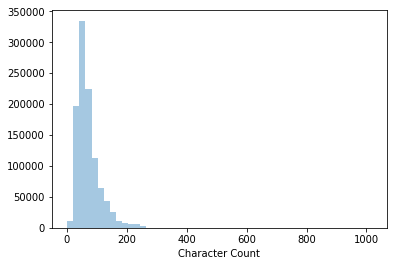

In [18]:
sns.distplot(train_set.char_count_full, kde=False, axlabel = 'Character Count')

In [19]:
iqr = np.subtract(*np.percentile(train_set.char_count_full, [75, 25])) #interquartile range
upper_bound_outlier = np.percentile(train_set.char_count_full, 75) + 1.5*iqr
print('Above {} characters documents are considered outliers'.format(upper_bound_outlier))

Above 145.0 characters documents are considered outliers


In [20]:
iqr = np.subtract(*np.percentile(train_set.word_density_full, [75, 25])) #interquartile range
upper_bound_outlier = np.percentile(train_set.word_density_full, 75) + 1.5*iqr
print('Above {} word density documents are considered outliers'.format(upper_bound_outlier))

Above 6.907969639468693 word density documents are considered outliers


The histogram is righ skewed showing that there are big outliers in terms of document lenght. Above 145 characters, documents are considered outliers of this data. Lets look at the same statistic by target.

In [21]:
# Target comparison
train_set[['word_count_full', 'target']].groupby('target').aggregate([min, np.mean, np.median, max])

word_count_full                      
                   min      mean median  max
target                                      
0                    1 12.510228     11  134
1                    1 17.238645     15   64

It seems that insincere questions tend to be more elaborate than sincere. On average there are 17 words per insincere questions instead of 13 words per sincere question. Now lets see if there are different distribution of the target in the outlier questions. 

In [22]:
criteria = (train_set.word_count_full < 3) | (train_set.char_count_full > 200) | (train_set.word_density_full > 10)
outliers = train_set[criteria]
proportion = 4458/(4458+12337)*100
print('Beign an outlier makes the insincere class proportion significantly higher ({}%)'.format(round(proportion)))
outliers['target'].value_counts()

Beign an outlier makes the insincere class proportion significantly higher (27%)


0    12337
1     4458
Name: target, dtype: int64

After testing multiple cutoff point for outliers, the `word_count` < 3, `char_count`> 200, and `word_density`>10 maximazises the insincere class. This criteria will be use to create an outlier feature and help the model with these types of questions. This will specially useful when looking into these documents after processing, its most likely that many will end up in cero words because of stopwords removal. 

## <font color='firebrick'>2. Text Cleaning, preprocessing, and Meta Feature extraction </font>
---

Before advancing to benchmark models and text features extraction, I will create the necesary descriptive variables before splitting the data. First, we will apply text cleaning process, this mean applying lowercasing + punctuation removal + special character removal + stopwords removal and lemmatization. Then I will extract meta features from this new cleaned questions. 

### 2.1 Text Preprocessing

In [23]:
stop_words = h.get_clean_stopwords(stopwords.words('english'))
train_set['qt_clean'] = train_set.question_text.progress_apply(lambda t: h.clean_text(t))
train_set['qt_clean_stop'] = train_set.question_text.progress_apply(lambda t: h.clean_text(t, stop_words = stop_words))

100%|██████████| 1048575/1048575 [01:25<00:00, 12209.71it/s]


Lets see the impact of the text preprocessing on the unigram and bigram plot.

100%|██████████| 64774/64774 [00:00<00:00, 354982.36it/s]


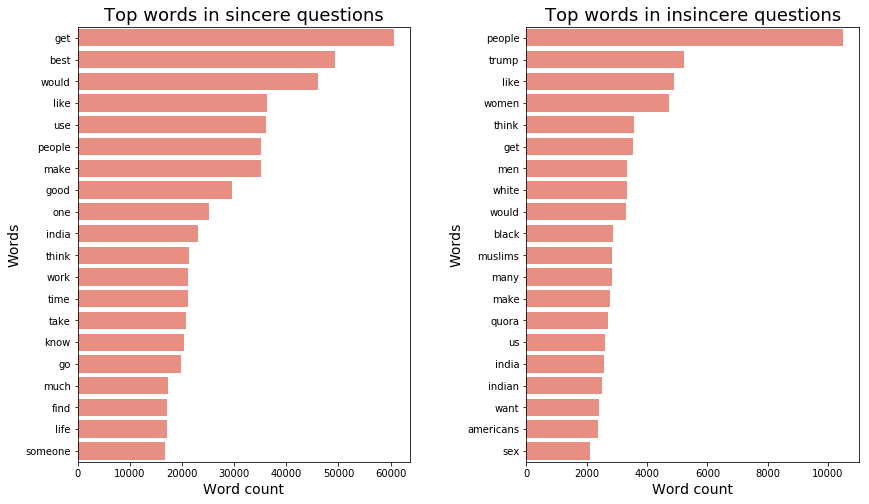

In [24]:
# Word Frequencies by target
wf_sincere = h.word_frequency(train_set.qt_clean_stop[train_set.target==0])
wf_insincere = h.word_frequency(train_set.qt_clean_stop[train_set.target==1])
h.comparison_plot(wf_sincere[:20],wf_insincere[:20],'word','wordcount', .35, figsize = (14,8))

The processing removed most of the noise words, improving interpretability. A fast view of the most frequent unigrams show that sincere questions have usual words related to asking verbs and overall neutral words. However, insincere unigrams have more sensitive nouns like indian, american, trump, etc. ¿But what about bigrams?

100%|██████████| 64774/64774 [00:00<00:00, 105047.39it/s]


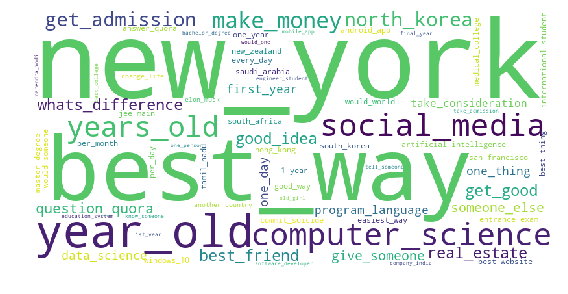

In [25]:
# Bigram Frequencies by target
stop_words = h.get_clean_stopwords(stopwords.words('english'))
wf_sincere = h.ngram_frequency(train_set.qt_clean_stop[train_set.target==0], 2)
wf_insincere = h.ngram_frequency(train_set.qt_clean_stop[train_set.target==1], 2)

h.plot_wordcloud(' '.join(wf_sincere.ngram), max_words=70, 
max_font_size=100, stop_words = stop_words, 
figure_size=(8,10), scale = 2, collocations = False)

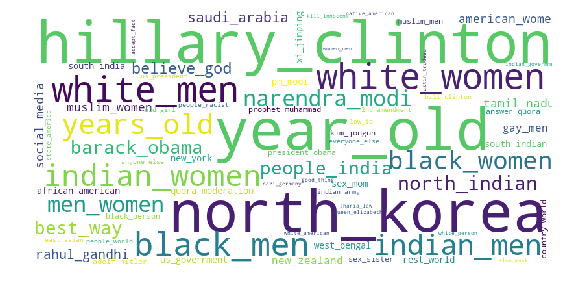

In [26]:
h.plot_wordcloud(' '.join(wf_insincere.ngram), max_words=70, 
max_font_size=100, stop_words = stop_words, 
figure_size=(8,10), scale = 2, collocations = False)

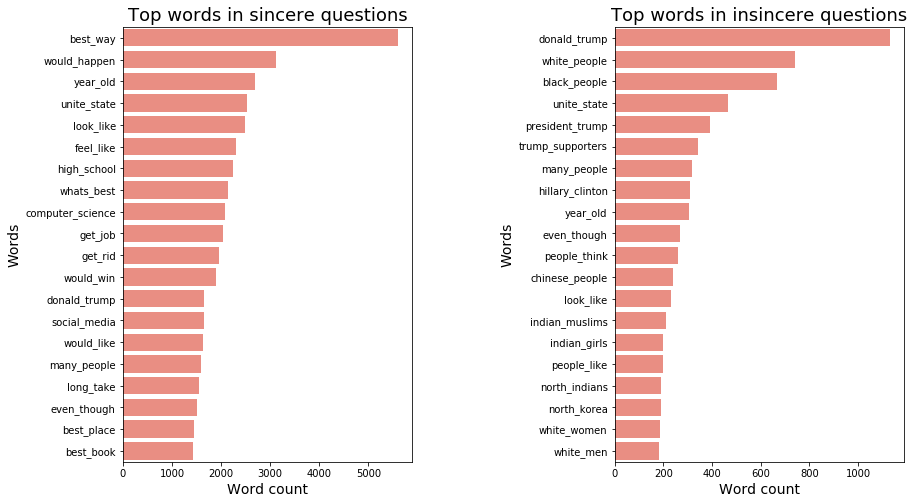

In [27]:
h.comparison_plot(wf_sincere[:20],wf_insincere[:20],'ngram','count', .7, figsize = (14,8))

Bigrams allow us a better understanding of what are the main ideas behind sincere and insincere questions. Its posible to see that many questions are related to find the `best` of place, book, way to do something. On the other hand, insincere questions focus **racial or gender or ethnic** group words. 

### 2.2 Documents Meta Features

In [30]:
# Creating several document derived features from clean questions
# Basic features
train_set['char_count'] = train_set.qt_clean_stop.progress_apply(len) # char clean count
train_set['word_count'] = train_set.qt_clean_stop.progress_apply(lambda x: len(x.split())) # word clean count
train_set['word_density'] = train_set.char_count / (train_set.word_count+1) # word density count
train_set['n_stopwords'] = train_set.qt_clean.progress_apply(lambda x: len([x for x in x.split() if x in stop_words]))
train_set['n_numbers'] = train_set.qt_clean_stop.progress_apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train_set['n_upper'] = train_set.qt_clean.progress_apply(lambda x: len([x for x in x.split() if x.isupper()]))

100%|██████████| 1048575/1048575 [00:03<00:00, 323423.13it/s]


In [31]:
# Sentiment features
train_set['polarity'] = train_set.qt_clean.progress_apply(lambda x: TextBlob(x).sentiment[0])
train_set['subjectivity'] = train_set.qt_clean.progress_apply(lambda x: TextBlob(x).sentiment[1])

sentimenter = Blobber(analyzer=NaiveBayesAnalyzer())
train_set['positivity'] = train_set.qt_clean.progress_apply(lambda x: h.NB_sentimenter(x, sentimenter))

100%|██████████| 1048575/1048575 [05:09<00:00, 3388.62it/s]


In [32]:
# Linguistic Features
train_set['noun_count'] = h.parallel_process(train_set.qt_clean, h.check_nouns)
train_set['verb_count'] = h.parallel_process(train_set.qt_clean, h.check_verbs)
train_set['adj_count'] = h.parallel_process(train_set.qt_clean, h.check_adj)
train_set['adv_count'] = h.parallel_process(train_set.qt_clean, h.check_adv)
train_set['pron_count'] = h.parallel_process(train_set.qt_clean, h.check_pron)

100%|██████████| 1.05M/1.05M [00:55<00:00, 18.8kit/s]  
1048572it [00:02, 490878.71it/s]
100%|██████████| 1.05M/1.05M [00:33<00:00, 31.4kit/s]  
1048572it [00:02, 488919.26it/s]
100%|██████████| 1.05M/1.05M [00:32<00:00, 32.5kit/s]  
1048572it [00:02, 436824.23it/s]
100%|██████████| 1.05M/1.05M [00:31<00:00, 32.9kit/s]  
1048572it [00:02, 475911.11it/s]
100%|██████████| 1.05M/1.05M [00:53<00:00, 19.6kit/s]  
1048572it [00:02, 483028.57it/s]


In [34]:
# outlier feature
train_set['is_outlier'] = criteria.astype('int') # binary

Lets see how informative these new feature are:

In [36]:
col = ['is_outlier', 'char_count', 'word_count', 'word_density', 'n_stopwords', 
       'n_numbers', 'n_upper', 'polarity', 'subjectivity', 'positivity',
       'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']

# ¿Are they informative of the target? (information gain analysis)
ig_score = mutual_info_classif(train_set[col], train_set.target)
ig_score_df = pd.DataFrame({'metafeatures':col, 
                       'inf_gain':ig_score})
ig_score_df = ig_score_df.sort_values('inf_gain', ascending = False)
ig_score_df

,metafeatures,inf_gain
14,pron_count,0.054920
12,adj_count,0.054221
11,verb_count,0.050600
13,adv_count,0.047004
10,noun_count,0.034176
2,word_count,0.031768
4,n_stopwords,0.026596
1,char_count,0.015916
7,polarity,0.011567
3,word_density,0.011279


Text(0.5, 0, 'Information Gain')

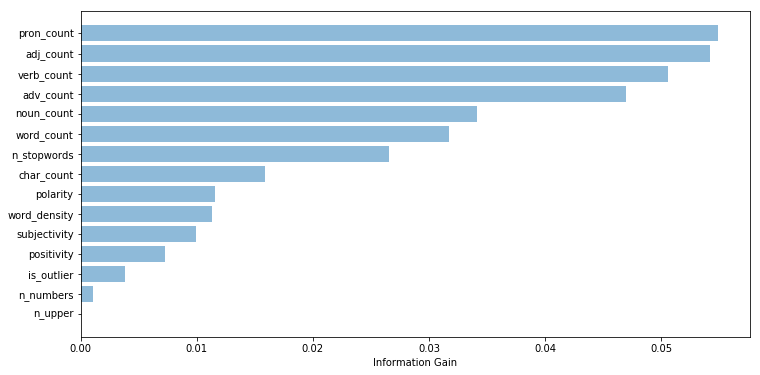

In [37]:
# Most informative ngrams
ig_score_df = ig_score_df.sort_values('inf_gain', ascending = True)

plt.figure(figsize=(12,6))
plt.barh(range(len(ig_score_df.metafeatures)),ig_score_df.inf_gain, align='center', alpha=0.5)
plt.yticks(range(len(ig_score_df.metafeatures)), ig_score_df.metafeatures)
plt.xlabel('Information Gain')

By univariate feature analysis, the metafeatures shows overall low information gain. The top feature is `adj_count`, which are adjective count. The lowest is the `n_upper`, which is the number of upper cased words in uncleaned text vector. 

In [67]:
# Saving Preprocessing 
with open('Data/train_preproc.pkl', 'wb') as output:
    pickle.dump(train_set, output, pickle.HIGHEST_PROTOCOL)

### 2.3 Train, test, valid, split

In [39]:
# Train Valid split
with open('Data/train_preproc.pkl', 'rb') as input:
    train_set = pickle.load(input)


# For further analysis and to avoid test leakage I will create a  
# train, test and valid set
pretrain_x, test_x, pretrain_y, test_y = train_test_split(train_set, 
                                                          train_set.target,
                                                          test_size = 0.3,
                                                          stratify = train_set.target,
                                                          random_state = 33)

train_x, valid_x, train_y, valid_y = train_test_split(pretrain_x, 
                                                      pretrain_y,
                                                      test_size = 0.2,
                                                      stratify = pretrain_y,
                                                      random_state = 33)

## <font color='firebrick'>3. Benchmark Models </font>
---

First, I will define a pipeline function that will allow me to perform easily text vectorization and model evaluation by 5 fold cross validation

In [40]:
# Defining pipeline and evaluation functions
def create_pipeline(learner = None, ngram = [1,1], 
                    term_count = 1, vocabulary = None):
    estimators = []
    estimators.append(('vect', CountVectorizer(ngram_range = [1,1], 
                                               min_df = term_count,
                                               vocabulary = vocabulary)))
    estimators.append(('tfidf', TfidfTransformer()))
    
    if (learner is not None):    
        estimators.append(('learner', learner))
        
    pipe = Pipeline(estimators)
    return(pipe)

def cv_evaluation(lrn, X, y, cv = 5, cpus = 5, verbose = False, seed = 33):  
    kfold = model_selection.KFold(n_splits=cv, random_state=seed)
    results = model_selection.cross_validate(lrn, X, y, scoring = 'f1',
                                              cv=kfold, n_jobs=cpus, 
                                              verbose = verbose, 
                                              return_train_score=True)
    results = pd.DataFrame(results).mean(axis=0)
    return(results)


For comparison, a naive model and a simple logistic regression model will be constructed from the unprocessed crude text. The naive models assumes all of the questions are sincere, since it is the predominant class. 

In [43]:
# Naive Model
lrn = DummyClassifier(random_state = 33)
pipe_lrn = create_pipeline(lrn)
results_mod = cv_evaluation(pipe_lrn, X = train_x.question_text, y = train_y)
print('The mean train {} and test CV {}.'.format(round(results_mod['train_score'], 2),round(results_mod['test_score'], 2)))

The mean train 0.06 and test CV 0.06.


As expected this score should be very close to zero. 

In [45]:
# baseline score: Logistic Regression 
lrn_basic = LogisticRegression(class_weight = 'balanced',
                               C = 1e10, # Large C for no regularization
                               random_state = 33, 
                               penalty = 'l1')
pipe_lrn = create_pipeline(lrn_basic)
results_mod = cv_evaluation(pipe_lrn, train_x.question_text, train_y)
print('The mean train {} and test CV {}.'.format(round(results_mod['train_score'], 2),round(results_mod['test_score'], 2)))

The mean train 0.71 and test CV 0.47.


The justification of benchmarking with crude text, is that the text preprocessing is also a mayor task in NLP, thus although cleaning is a standard procedure, how you clean your text defines most of the time model performance. So I will use this score as a baseline on how much I improved my model by the preprocessing step

I used high `C`parameter in `LogisticRegression` because natively this algorithm implements regularization. Regularization is a method that constrains or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting. A high `C` parameter discourages regularization. 

The CV score for train and test are significantly different from each other, which implies strong overfitting. 

<module 'matplotlib.pyplot' from '/Users/Fabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

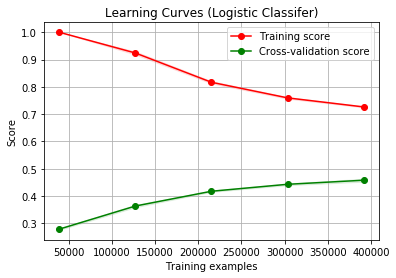

In [46]:
h.plot_learning_curve(pipe_lrn, train_x.question_text, train_y, cv=3, n_jobs=3, 
                      title = 'Learning Curves (Logistic Classifer)')    

 Its evident that this model overfits severely due to its difference between training and CV score. 

In [47]:
# Validating preprocessing with the same base learner
results_mod = cv_evaluation(pipe_lrn, train_x.qt_clean_stop, train_y)
print('The mean train {} and test CV {}.'.format(round(results_mod['train_score'], 2),round(results_mod['test_score'], 2)))

The mean train 0.66 and test CV 0.46.


If we compare the same baseline learner but using preprocessed data, then the different between training and CV score get smaller indicating that the preprocessing step reduced noise, and overfitting. CV score was practically the same as before. 

## <font color='firebrick'>4. Feature selection of text features </font>
---

Because of the inmense amount of text features, I will implement a feature selection procedure to reduce the feature pool to the most relevant text ngrams. I will use chi-squared test to check is dependence with the target variable. The cutoff value will be those text features that have a probability lower equal to than 0.001.

In [49]:
# Chi-Squared for Feature Selection
 
tfidf = TfidfVectorizer(ngram_range = [1,3])  
train_tfidf = tfidf.fit_transform(train_x.qt_clean_stop) 
chi2score = chi2(train_tfidf, train_y)
scores_df = pd.DataFrame({'words':tfidf.get_feature_names(), 
                       'chi_squared':chi2score[0],
                       'prob':chi2score[1]})

In [50]:
# Get features that have a prob << 0.001
best_chi = scores_df[scores_df.prob <= 0.001].sort_values(['chi_squared'], ascending = False)

N = 50
best_N_chi = best_chi[:N].sort_values(['chi_squared'])

Text(0.5, 0, 'Chi_squared')

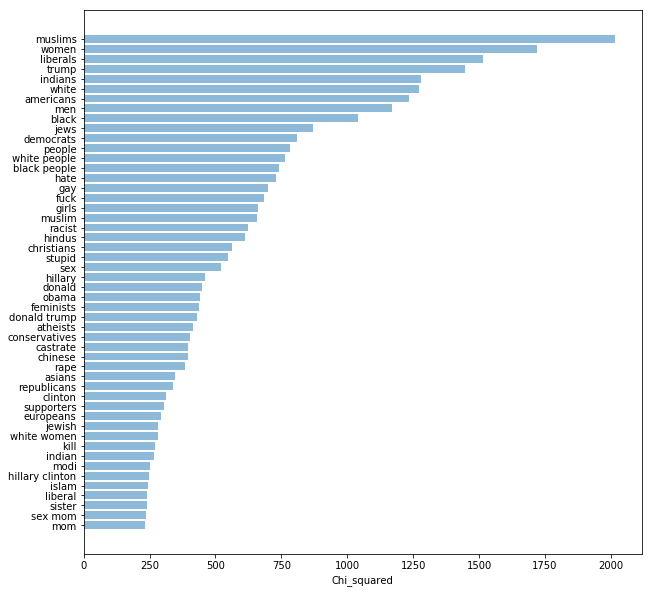

In [51]:
# Most informative ngrams
plt.figure(figsize=(10,10))
plt.barh(range(N),best_N_chi.chi_squared, align='center', alpha=0.5)
plt.yticks(range(N), best_N_chi.words)
plt.xlabel('Chi_squared')

In [52]:
# Construct new vocabulary with these words and run logistic reg
tfidf = TfidfVectorizer(ngram_range = [1,3], vocabulary = best_chi.words)  
train_tfidf = tfidf.fit_transform(train_x.qt_clean_stop) 

# Logistic Regression with feature selection
# Feature selection allows to reduce barely afecting baseline performance
results_mod = cv_evaluation(lrn_basic, train_tfidf, train_y)
print('The mean train {} and test CV {} of ngrams.'.format(round(results_mod['train_score'], 2),round(results_mod['test_score'], 2)))

The mean train 0.5 and test CV 0.49 of ngrams.


In [53]:
# Saving text feature selection
with open('Data/text_feature_selection.pkl', 'wb') as output:
    pickle.dump(best_chi, output, pickle.HIGHEST_PROTOCOL)

## <font color='firebrick'>5. Modelling </font>

I will first performe the text features classification with the best chi-squared features. The prediction will be use to feed a second modelling step of metafeatures + top 

In [187]:
# We will model text features selected by chi_squared
with open('Data/text_feature_selection.pkl', 'rb') as input:
    best_chi = pickle.load(input)    


# Creating train and valid vectors
pipe_vect = create_pipeline(ngram = [1,3], vocabulary = best_chi.words)
train_vect = pipe_vect.fit_transform(train_x.qt_clean_stop)
valid_vect = pipe_vect.transform(valid_x.qt_clean_stop)
test_vect = pipe_vect.transform(test_x.qt_clean_stop)

In [188]:
# Defining Models to use
log = LogisticRegression(class_weight = 'balanced', random_state = 33,
                                       solver = 'lbfgs', C = 0.5, verbose = True)
nb = naive_bayes.ComplementNB()
lgb = lightgbm.LGBMClassifier(random_state = 33, class_weight = 'balanced',
                                                objective = 'binary', n_jobs = 5,
                                                n_estimators = 500)

models = {'logreg': log,
          'naive_bayes': nb,
          'lightgbm': lgb
          }

models['ensemble'] = VotingClassifier(estimators = [('logreg', log),
      ('nb', nb), ('lgb', lgb)], voting='soft', n_jobs = 5)


In [189]:
# Defining testing function
def testing_models(tr_x, tr_y, val_x, val_y, models, te_x = None, te_y = None):
    
    mod_results = {}
    
    for model in models:
        learner = models[model]
        results = {}
        print('Modelling with', model, '...')

        learner.fit(tr_x, tr_y)
        predictions_train = learner.predict_proba(tr_x)
        predictions_valid = learner.predict_proba(val_x)
        
        cut_off = threshold_search(tr_y, predictions_train[:,1])
        pred_val_threshol = predictions_valid[:,1] > cut_off['threshold']
        
        results['train_score'] = cut_off['f1']
        results['val_score'] = metrics.f1_score(val_y, pred_val_threshol)
        
        if te_x is not None and te_y is not None:
            print("Test data was passed, refitting model...")
            learner2 = models[model]
            
            if (scipy.sparse.issparse(tr_x)):
                bind_train = scipy.sparse.vstack((tr_x,val_x))
            else:
                bind_train = [*tr_x, *val_x]
            bind_y = tr_y.append(val_y)
            learner2.fit(bind_train, bind_y)
            
            predictions_train = learner2.predict_proba(bind_train)
            predictions_test = learner2.predict_proba(te_x)

            cut_off = threshold_search(bind_y, predictions_train[:,1])
            pred_test_threshol = predictions_test[:,1] > cut_off['threshold']
            results['test_score'] = metrics.f1_score(te_y, pred_test_threshol)
            results['fitted_model_test'] = learner2
        
        results['fitted_model_valid'] = learner
        results['threshold'] = cut_off['threshold']

        print(results)
        mod_results[model] = results   
    return(mod_results)

def threshold_search(y_true, y_proba):
    'https://www.kaggle.com/ryanzhang/tfidf-naivebayes-logreg-baseline'
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [190]:
# Finding best text feature model
text_results = testing_models(train_vect, train_y, valid_vect, valid_y, models, te_x = test_vect, te_y = test_y)


Modelling with logreg ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished


Test data was passed, refitting model...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


{'train_score': 0.5856073526624976, 'val_score': 0.5747280655517752, 'test_score': 0.5791751585793126, 'fitted_model_test': LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=33,
          solver='lbfgs', tol=0.0001, verbose=True, warm_start=False), 'fitted_model_valid': LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=33,
          solver='lbfgs', tol=0.0001, verbose=True, warm_start=False), 'threshold': 0.8200000000000001}
Modelling with naive_bayes ...
Test data was passed, refitting model...
{'train_score': 0.5314935802033146, 'val_score': 0.5185970224577341, 'test_score': 0.5235885357151187, 'fitted_model_test': ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False), 'fitted_

The best results is lightGBM = 'test_score': 0.5813463564109931, the Second best is Voteclassifier = 'val_score': 0.5784845076183659. The classification result of lightGBM will be added as a feature with the metafeatures.

In [194]:
# 6.2 Metafeatures classification
# This sequential classification will stack the text classification prediction
# and the 500 most importante words by feature selection

N = 500
# Creating train and valid vectors
pipe_vect2 = create_pipeline(ngram = [1,3], vocabulary = best_chi.words[:N])
ss_train_vect = pipe_vect2.fit_transform(train_x.qt_clean_stop)
ss_valid_vect = pipe_vect2.transform(valid_x.qt_clean_stop)
ss_test_vect = pipe_vect2.transform(test_x.qt_clean_stop)

train_text_feat = ss_train_vect.todense()
train_text_feat = pd.DataFrame(train_text_feat,columns = best_chi.words[:N])

valid_text_feat = ss_valid_vect.todense()
valid_text_feat = pd.DataFrame(valid_text_feat,columns = best_chi.words[:N])

test_text_feat = ss_test_vect.todense()
test_text_feat = pd.DataFrame(test_text_feat,columns = best_chi.words[:N])


In [195]:
# Concatenating metafeatures + top text features + prediction feature
# training
train_feat_x = pd.concat([train_x.reset_index(drop=True), 
                  train_text_feat.reset_index(drop=True)], axis=1)

#train_feat_x = train_x
text_lrn = text_results['ensemble']['fitted_model_test']
text_thr = text_results['ensemble']['threshold']
pred_train = text_lrn.predict_proba(train_vect)
train_feat_x['text_pred'] = (pred_train[:,1] > text_thr).astype('int')

# validation
val_feat_x = pd.concat([valid_x.reset_index(drop=True), 
                  valid_text_feat.reset_index(drop=True)], axis=1)

#val_feat_x = valid_x
pred_val = text_lrn.predict_proba(valid_vect)
val_feat_x['text_pred'] = (pred_val[:,1] > text_thr).astype('int')

# test
test_feat_x = pd.concat([test_x.reset_index(drop=True), 
                  test_text_feat.reset_index(drop=True)], axis=1)

#test_feat_x = test_x
pred_test = text_lrn.predict_proba(test_vect)
test_feat_x['text_pred'] = (pred_test[:,1] > text_thr).astype('int')


In [196]:
# Dropping unnecesary columns
train_feat_x = train_feat_x.drop(['qid', 'question_text', 'target', 'qt_clean', 'qt_clean_stop'], axis = 1)
val_feat_x = val_feat_x.drop(['qid', 'question_text', 'target', 'qt_clean', 'qt_clean_stop'], axis = 1)
test_feat_x = test_feat_x.drop(['qid', 'question_text', 'target', 'qt_clean', 'qt_clean_stop'], axis = 1)

In [197]:
# Performing Standarization
min_max_scaler = MinMaxScaler()
train_feat_x = min_max_scaler.fit_transform(train_feat_x)
val_feat_x = min_max_scaler.transform(val_feat_x)
test_feat_x = min_max_scaler.transform(test_feat_x)

In [199]:
# Finding best metafeature model
models = {'logreg': log,
          'naive_bayes': nb,
          'lightgbm': lgb
          }

models['ensemble'] = VotingClassifier(estimators = [('logreg', log),
      ('nb', nb), ('lgb', lgb)], voting='soft', n_jobs = 1)

# 
meta_results = testing_models(train_feat_x, train_y, val_feat_x, valid_y, models, te_x=test_feat_x, te_y=test_y)

Modelling with logreg ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s finished


Test data was passed, refitting model...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.6s finished


{'train_score': 0.593046680921012, 'val_score': 0.5880591054313098, 'test_score': 0.5791859476815563, 'fitted_model_test': LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=33,
          solver='lbfgs', tol=0.0001, verbose=True, warm_start=False), 'fitted_model_valid': LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=33,
          solver='lbfgs', tol=0.0001, verbose=True, warm_start=False), 'threshold': 0.84}
Modelling with naive_bayes ...
Test data was passed, refitting model...
{'train_score': 0.5983354375298776, 'val_score': 0.5928200049517206, 'test_score': 0.582755522793762, 'fitted_model_test': ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False), 'fitted_model_valid': Co

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.3s finished


Test data was passed, refitting model...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.6s finished


{'train_score': 0.607225720914816, 'val_score': 0.5922055510282346, 'test_score': 0.5853167501789549, 'fitted_model_test': VotingClassifier(estimators=[('logreg', LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=33,
          solver='lbfgs', tol=0.0001, verbose=True, warm_start=False)), ('n...ambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), 'fitted_model_valid': VotingClassifier(estimators=[('logreg', LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=33,
          solver='lbfgs', tol=0.0001, verbose=True, warm_start=False)), ('n...ambda=0.0,
        silent=True, subsampl